# Perceptron


https://en.wikipedia.org/wiki/Perceptron

In this notebook, we create a perceptron which is going to help us classify whether an image is a cat or not. Perceptrons cannot be trained to recognize multiple classes since they are only capable of linear classification.

This uses logistic regression (binary output) instead of linear regression (continuous output).

We don't use backprop in a single perceptron, it is only used for multilayer perceptrons.

In [1]:
import numpy as np
import h5py

### Import train dataset

In [2]:
train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
train_dataset.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [3]:
classes = np.array(train_dataset['list_classes'][:])
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [4]:
train_set_x_orig = np.array(train_dataset['train_set_x'][:])
train_set_y_orig = np.array(train_dataset['train_set_y'][:])

### Import test dataset

In [5]:
test_dataset = h5py.File('datasets/test_catvnoncat.h5', 'r')
test_dataset.keys()

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

In [6]:
test_set_x_orig = np.array(test_dataset['test_set_x'][:])
test_set_y_orig = np.array(test_dataset['test_set_y'][:])

### Reshape output labels

Change label shapes from (50,) to (1,50)

In [7]:
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

### Sample image and label

Prediction: [0]


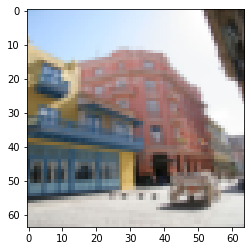

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_set_x_orig[23])
print('Prediction: ' + str(train_set_y[:,23]))

### Extract dimensions

In [9]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]

### Reshape input images

Convert images from (m_train, num_px, num_px, 3) to (num_px * num_px * 3, m_train).

This can be done using the trick below. We take the last dimension and put it in the first place. Then -1 automatically squishes all other dimensions after it. Lastly, we need to transpose since the pixels dimension comes before the m_train dimension.

In [10]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print(train_set_x_orig.shape)
print(train_set_x_flatten.shape)

(209, 64, 64, 3)
(12288, 209)


### Standardize dataset

Divide the entire dataset by 255.

In [11]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

### Activation function

In [12]:
def activation_function(z):
    # Sigmoid
    s = 1 / (1+np.exp(-z))
    return s

### Initialize parameters

In [13]:
def weights_and_bias(dim):
    w = np.zeros((dim,1))
    b = 0.0
    return w,b

### Forward and backward propagation

We pass the weights and bias as parameters because we don't want to access them as global variables.

In [14]:
def propagate(w, b, X, Y):
    # X.shape = (image_date, no_of_samples)
    # Y.shape = (1, no_of_samples)
    
    # Forward propagation
    m = X.shape[1]
    Z = np.dot(w.T, X) + b
    A = activation_function(Z)
    
    eps = 0.000001
    
    # Store cost so that we can draw a graph later on.
    cost = (-1/m) * ((np.dot(np.log(A+eps), Y.T)) + np.dot(np.log(1-A+eps), (1-Y).T))
    
    # Backward propagation
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    cost = np.squeeze(np.array(cost))
    
    return dw, db, cost

### Gradient descent

In [15]:
import copy

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.005):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations): # Number of iterations
        dw, db, cost = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        costs.append(cost)
        #print('Cost after iteration %i: %f' % (i, cost))
    
    return w, b, dw, db, costs        

### Predict

In [16]:
def predict(w, b, X):
    m = X.shape[1]
    Y = np.zeros((1,m))
    w = w.reshape((X.shape[0], 1))   # TODO: why?
    A = activation_function(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]): # m
        if A[0, i] > 0.5: Y[0, i] = 1
        else: Y[0, i] = 0
    
    return Y    

### Model

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=100, learning_rate=0.005):
    w, b = weights_and_bias(X_train.shape[0])
    
    w, b, dw, db, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    
    Y_train_preds = predict(w, b, X_train)
    Y_test_preds = predict(w, b, X_test)
    
    print('Train accuracy: {} %'.format(100 - np.mean(np.abs(Y_train_preds - Y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(Y_test_preds - Y_test)) * 100))
    
    d = {'costs': costs,
         'Y_train_preds' : Y_train_preds,
         'Y_test_preds': Y_test_preds,
         'w' : w,
         'b' : b,
         'learning_rate' : learning_rate,
         'num_iterations': num_iterations}
    
    return d

In [18]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1000, learning_rate=0.005)

Train accuracy: 96.65071770334929 %
Test accuracy: 72.0 %


### Cost function plot

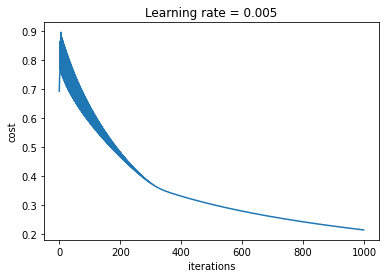

In [19]:
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Learning rate = ' + str(logistic_regression_model['learning_rate']))
plt.show()

### Choice of learning rate

Training model with learning rate: 0.1
Train accuracy: 100.0 %
Test accuracy: 70.0 %
---
Training model with learning rate: 0.01
Train accuracy: 99.52153110047847 %
Test accuracy: 68.0 %
---
Training model with learning rate: 0.001
Train accuracy: 88.99521531100478 %
Test accuracy: 64.0 %
---
Training model with learning rate: 0.0001
Train accuracy: 68.42105263157895 %
Test accuracy: 36.0 %
---
Training model with learning rate: 1e-05
Train accuracy: 65.55023923444976 %
Test accuracy: 34.0 %
---


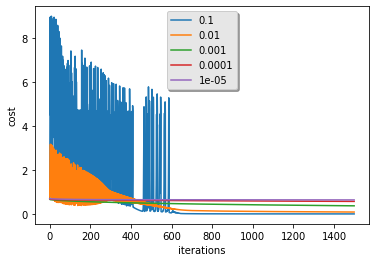

In [20]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
models = {}

for lr in learning_rates:
    print ('Training model with learning rate: ' + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr)
    print('---')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]['costs']), label=str(models[str(lr)]['learning_rate']))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()